In [81]:
#1D non-isothermal

'''
 - I dont know if we can do PMR simulation with this because the removal of h2 will become problem
'''

from scipy.integrate import solve_bvp
import numpy as np
import matplotlib.pyplot as plt

In [82]:
def heats(T):
    #heats of reaction and heat capacity calculation from NIST
    t = T/1000

    #CH4
    A =	-0.703029
    B =	108.4773
    C =	-42.52157
    D =	5.862788
    E =	0.678565
    F =	-76.84376
    G =	158.7163
    H =	-74.87310

    dH_CH4 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CH4 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #H2O
    A =   30.09200
    B =   6.832514
    C =   6.793435
    D =  -2.534480
    E =   0.082139
    F =  -250.8810
    G =   223.3967
    H =  -241.8264

    dH_H2O = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_H2O = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #CO
    A =   25.56759
    B =   6.096130
    C =   4.054656
    D =  -2.671301
    E =   0.131021
    F =  -118.0089
    G =   227.3665
    H = -110.5271

    dH_CO = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CO = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #CO2
    A =   24.99735
    B =   55.18696
    C =  -33.69137
    D =   7.948387
    E =  -0.136638
    F =  -403.6075
    G =   228.2431
    H =  -393.5224

    dH_CO2 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CO2 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #H2
    A =  33.066178
    B = -11.363417
    C =  11.432816
    D = -2.772874
    E = -0.158558
    F = -9.980797
    G =  172.707974
    H =  0.0

    dH_H2 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_H2 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #Ar
    A =	20.78600
    B =	2.825911*10**-7
    C =	-1.464191*10**-7
    D =	1.092131*10**-8
    E =	-3.661371*10**-8
    F =	-6.197350
    G =	179.9990
    H =	0

    Cp_Ar = A + B*t + C*t**2 + D*t**3 + E/(t**2) #J/mol K

    dHsmr = (3*dH_H2 + dH_CO - dH_CH4 - dH_H2O + 206.1)*10**3 #J/mol
    dHwgs = (dH_H2 + dH_CO2 - dH_CO - dH_H2O - 41.15)*10**3 #J/mol
    # print(dHsmr)
    # print(dHwgs)
    # print([Cp_CH4, Cp_H2O, Cp_CO, Cp_CO2, Cp_H2])
    return dHsmr, dHwgs, [Cp_CH4, Cp_H2O, Cp_CO, Cp_CO2, Cp_H2, Cp_Ar]

In [ ]:
#WANT TO RE-ARANGE CONSTANTS

#reactor constants
L = 0.0609 #m
R_inner = 2.39/1000 #m
R_outer = 3.5/1000 #m

A = np.pi * ((R_outer)**2-(R_inner)**2) #m^2 AXIAL AREA (GAS FLOW)
V = A*L #m^3
S = 2*np.pi*R_outer*L #m^2 RADIAL AREA (HEAT FLUX AND REACTION)

h2Removal = 0 #change to 1 if there is removal of hydrogen

#gas flow constants WHEN CHANGING THE TEMPERATURE YOU NEED TO ADJUST THE INITIAL GUESS -- USING ODEINT MIGHT BE FOR BETTER CONVERSION
Tin = 622+273 #K
P = 1 #bar or atm
Rgas = 8.3144598 * 10**-5

sccm0 = np.array([16.16, 48.48, 0, 0, 10, 5])
mols0 = sccm0/22400 * 273 / Tin * P / 1 / 60
y0 = mols0/sum(mols0)
Ctot = P/(Rgas * Tin)
C0 = y0*Ctot
C0 = np.concatenate((C0, [Tin]))
print(C0)

u0 = sum(sccm0) * 273 / Tin * P / 1 / 60 #cm^3/sec
v0 = u0 / (100**3 * A) #m/sec

#rate equation constants
Rreact = 8.314 #J / mol·K
Easmr = 165.740 #kJ/mol
Asmr = 1.68*10**8
Eawgs = 89.23 #kJ/mol
Awgs = 9.90*10**3

Ku = 1

I = 9 #curent in Amps
F = 96485 #faradays constant

U = 0.116 #J (s K)^-1.
Ts = 298 #K

q_furn= 0.25 #J/s

#velocity balance
MM = np.array([16.04, 18.01528, 28.01, 44.009, 2.016, 39.948])
m0 = v0 * A * np.sum(C0[:6]*MM)
print(m0) #kg/s


[2.72679841e+00 8.18039523e+00 0.00000000e+00 0.00000000e+00
 1.68737525e+00 8.43687627e-01 8.95000000e+02]
9.239839843734845e-05


In [84]:
x_num = 20

x_pts = np.linspace(0,L,x_num)

#initial guess array
init_guess = np.zeros((7, x_num))
init_guess[0, :] = C0[0]
init_guess[1, :] = C0[1]
init_guess[2, :] = C0[2]
init_guess[3, :] = C0[3]
init_guess[4, :] = C0[4]  
init_guess[5, :] = C0[5]
init_guess[6, :] = C0[6]

v = np.linspace(v0, 0.02, x_num)

def odes(x, C): #dy/dt = f(x)
    T = C[6]
    Ctot = P/(Rgas * T)

    y = C[:6]/np.sum(C[:6], axis = 0)

    global v
    vuse = v[:len(T)]
    print(vuse)

    Keqsmr = (101325/100000)**2 * np.exp(-26830/T + 30.114)
    Keqwgs = np.exp(4400/T - 4.036)

    rsmr = S/V*Ku*Asmr*np.exp(-Easmr*1000/Rreact/T)*(y[0]*y[1]-(P**2)*y[2]*(y[4]**3)/Keqsmr)
    rwgs = S/V*Ku*Awgs*np.exp(-Eawgs*1000/Rreact/T)*(y[1]*y[2]-y[3]*y[4]/Keqwgs)
    rh2r = I/(2*F*L) #have not confirmed if this is correct

    dHsmr, dHwgs, Cps = heats(T)

    Cpg = np.sum(y[:6, :]*Cps, axis=0)

    ch4 = (-rsmr)/vuse
    h2o = (-rsmr - rwgs)/vuse
    co = (rsmr - rwgs)/vuse
    co2 = (rwgs)/vuse
    h2 = (3*rsmr + rwgs + h2Removal*rh2r)/vuse
    ar = np.zeros(len(T))
    Temp = (S*U*(-T[:] + Ts) - V*(dHsmr*rsmr + dHwgs*rwgs) + q_furn)/(vuse*Ctot*Cpg*V)

    v[:len(rsmr)] = ((-1-1+1+3)*rsmr + (-1-1+1+1)*rwgs)/(ch4+h2o+co+co2+h2+ar)
    print(v)
    
    return np.vstack([ch4, h2o, co, co2, h2, ar, Temp])

def bcs(yleft, yright):
    return np.array(yleft-C0)

soln = solve_bvp(odes, bcs, x_pts, init_guess, max_nodes=x_num, tol = 0.000001)


[0.01971204 0.01972719 0.01974235 0.0197575  0.01977266 0.01978782
 0.01980297 0.01981813 0.01983328 0.01984844 0.0198636  0.01987875
 0.01989391 0.01990906 0.01992422 0.01993938 0.01995453 0.01996969
 0.01998484 0.02      ]
[0.01971204 0.01972719 0.01974235 0.0197575  0.01977266 0.01978782
 0.01980297 0.01981813 0.01983328 0.01984844 0.0198636  0.01987875
 0.01989391 0.01990906 0.01992422 0.01993938 0.01995453 0.01996969
 0.01998484 0.02      ]
[0.01971204 0.01972719 0.01974235 0.0197575  0.01977266 0.01978782
 0.01980297 0.01981813 0.01983328 0.01984844 0.0198636  0.01987875
 0.01989391 0.01990906 0.01992422 0.01993938 0.01995453 0.01996969
 0.01998484 0.02      ]
[0.01971204 0.01972719 0.01974235 0.0197575  0.01977266 0.01978782
 0.01980297 0.01981813 0.01983328 0.01984844 0.0198636  0.01987875
 0.01989391 0.01990906 0.01992422 0.01993938 0.01995453 0.01996969
 0.01998484 0.02      ]
[0.01971204 0.01972719 0.01974235 0.0197575  0.01977266 0.01978782
 0.01980297 0.01981813 0.01983328

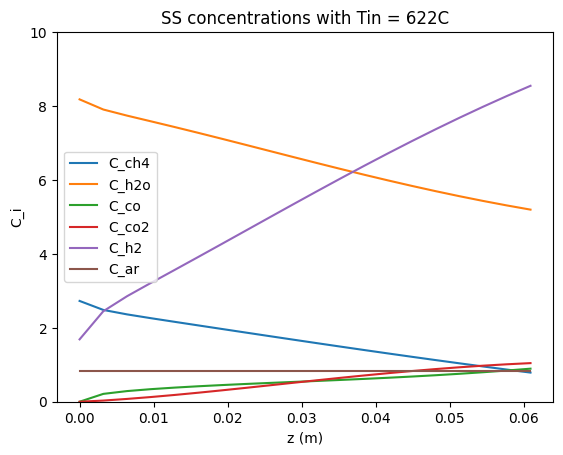

In [85]:
plt.plot(soln.x, soln.y[0], label='C_ch4')
plt.plot(soln.x, soln.y[1], label='C_h2o')
plt.plot(soln.x, soln.y[2], label='C_co')
plt.plot(soln.x, soln.y[3], label='C_co2')
plt.plot(soln.x, soln.y[4], label='C_h2')
plt.plot(soln.x, soln.y[5], label='C_ar')
plt.ylim(0, 10)
plt.xlabel('z (m)')
plt.ylabel('C_i')
plt.title(f'SS concentrations with Tin = {Tin-273}C')
plt.legend()

Text(0.5, 1.0, 'Temperature profile with Tin = 622C')

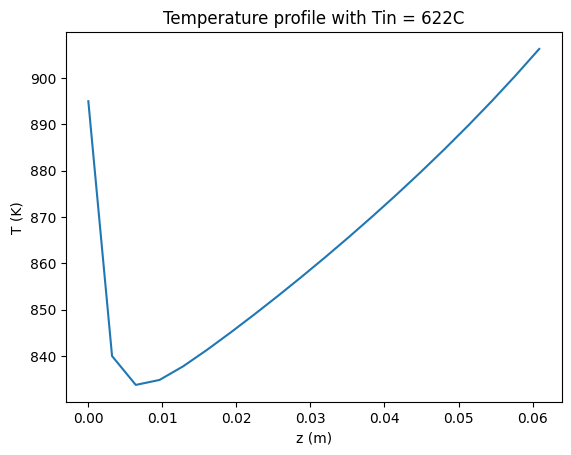

In [86]:
plt.plot(soln.x, soln.y[6])
plt.xlabel('z (m)')
plt.ylabel('T (K)')
plt.title(f'Temperature profile with Tin = {Tin-273}C')

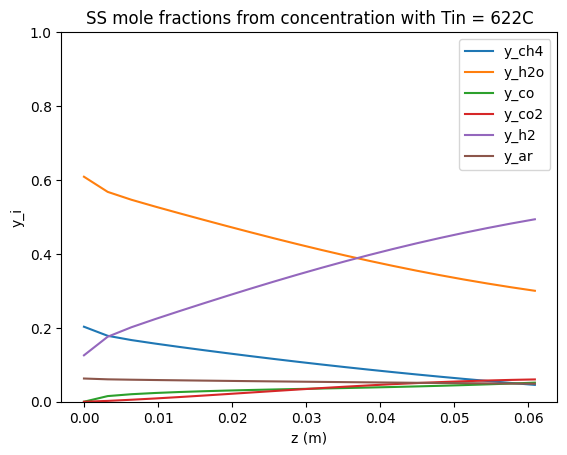

In [87]:
#mole fraction calculation
yplot = soln.y[:6]/np.sum(soln.y[:6], axis = 0)
plt.plot(soln.x, yplot[0], label='y_ch4')
plt.plot(soln.x, yplot[1], label='y_h2o')
plt.plot(soln.x, yplot[2], label='y_co')
plt.plot(soln.x, yplot[3], label='y_co2')
plt.plot(soln.x, yplot[4], label='y_h2')
plt.plot(soln.x, yplot[5], label='y_ar')
plt.ylim(0, 1)
plt.xlabel('z (m)')
plt.ylabel('y_i')
plt.title(f'SS mole fractions from concentration with Tin = {Tin-273}C')
plt.legend()

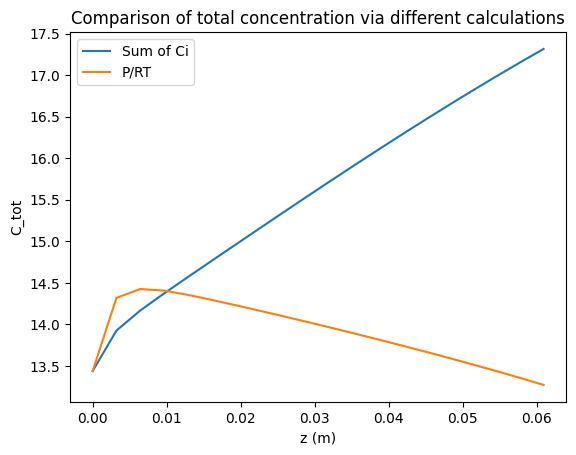

In [88]:
#comparison of P/RT vs total conc
Csum = np.sum(soln.y[:6], axis = 0)
plt.plot(soln.x, Csum, label='Sum of Ci')
plt.plot(soln.x, P/(Rgas * soln.y[6]), label='P/RT')
plt.xlabel('z (m)')
plt.ylabel('C_tot')
plt.title(f'Comparison of total concentration via different calculations')
plt.legend()

In [89]:
#Mass balance does NOT line up (velocity is the culprid probably)
#v0 * A * sum (C0 * MM) vs v0(1+2X) * A * sum (C-1 * MM)
m0 = v0 * A * np.sum(C0[:6]*MM)
y = soln.y[:6,-1]/np.sum(soln.y[:6,-1])
mf = v[-1] * A * np.sum(y*MM) * P/(Rgas * soln.y[6,-1])

print(m0)
print("%e" % mf)
print(f'mass balance off by {abs(mf - m0)/mf *100}%')

9.239839843734845e-05
7.185211e-05
mass balance off by 28.595250720529382%


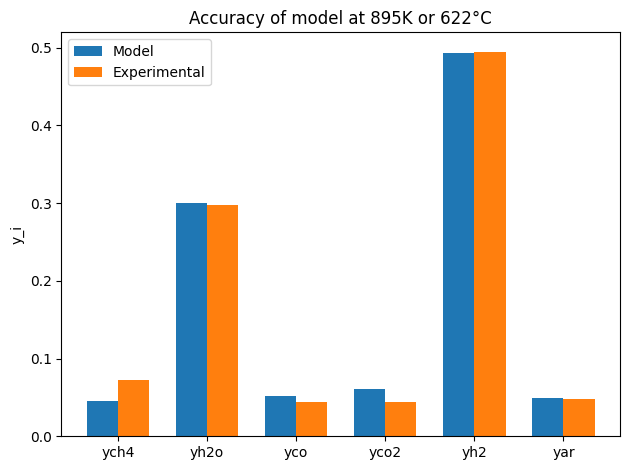

1.0


In [90]:
# Assign experimental data based on temperature
if Tin == 622 + 273:
    yexp = [0.071787506, 0.298008466, 0.043658696, 0.043658696, 0.495104008, 0.047782628]
elif Tin == 721 + 273:
    yexp = [0.019206098, 0.189598069, 0.090570208, 0.034350264, 0.619497555, 0.046777807]
elif Tin == 573 + 273:
    yexp = [0.101830373, 0.416886827, 0.02267593, 0.043676434, 0.365008486, 0.04992194]
elif Tin == 522 + 273:
    yexp = [0.135048125, 0.331577273, 0.010516725, 0.034486466, 0.436794105, 0.051577306]
else:
    print('Sorry, we dont have experimental data for that temperature.')
    yexp = [0, 0, 0, 0, 0, 0]


# Define categories
categories = ['ych4', 'yh2o', 'yco', 'yco2', 'yh2', 'yar']
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Plot
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, yplot[:6,-1], width, label='Model')
bars2 = ax.bar(x + width/2, yexp, width, label='Experimental')

# Labels and legend
ax.set_ylabel('y_i')
ax.set_title(f'Accuracy of model at {Tin}K or {Tin - 273}°C')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.tight_layout()
plt.show()

print(np.sum(yplot[:6,-1]))